In [7]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import pathlib
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
ROOT_DIR = pathlib.Path().absolute()
DATA_DIR = ROOT_DIR / "data"
RANDOM_SEED = 42

## Загрузка и обзор данных

In [8]:
df_trends = pd.read_csv(DATA_DIR / "trends_description.csv")
df = pd.read_csv(DATA_DIR / "train.csv")
df_test = pd.read_csv(DATA_DIR / "test.csv")
df.head()



,Unnamed: 0,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
0,0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортиме...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1428,6.0,"{PRICE,PROMOTIONS}",Можно немного скинуть минимальную сумму заказа...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
for i in range(50):
    df.rename(columns={f"trend_id_res{i}": i}, inplace=True)
#df["labels"] = df.drop('index',axis=1).drop('assessment',axis=1).drop('tags',axis=1).drop('text',axis=1).drop('Unnamed: 0',axis=1).apply(lambda r: r.index[r.ne(0)].to_list(), axis=1)
df.head()

,Unnamed: 0,index,assessment,tags,text,0,1,2,3,4,...,40,41,42,43,44,45,46,47,48,49
0,0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортиме...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1428,6.0,"{PRICE,PROMOTIONS}",Можно немного скинуть минимальную сумму заказа...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Предобработка данных

In [10]:
df.head()

,Unnamed: 0,index,assessment,tags,text,0,1,2,3,4,...,40,41,42,43,44,45,46,47,48,49
0,0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортиме...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1428,6.0,"{PRICE,PROMOTIONS}",Можно немного скинуть минимальную сумму заказа...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df.drop(columns=['index','Unnamed: 0', 'assessment'],axis=1, inplace=True)
df.head()

,tags,text,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортиме...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"{PRICE,PROMOTIONS}",Можно немного скинуть минимальную сумму заказа...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


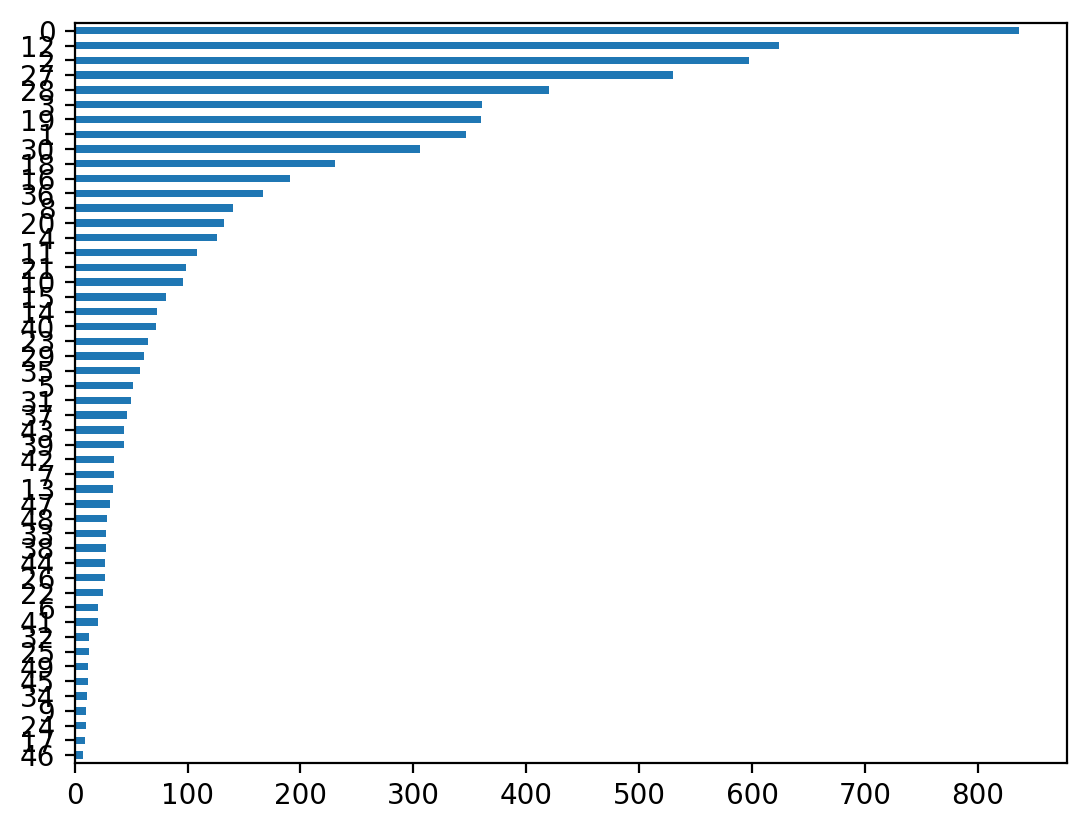

In [13]:
LABEL_COLUMNS = df.columns.tolist()[2:]

df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

Tokenization

In [15]:
BERT_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

c:\Users\Katie\miniconda3\envs\pl\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Let’s try it out on a sample comment

In [17]:
sample_row = df.iloc[16]
sample_comment = sample_row.text
sample_labels = sample_row[LABEL_COLUMNS]
print(sample_comment)
print()
print(sample_labels.to_dict())

Расширить ассортимент товаров

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 1, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0}


In [18]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [19]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [20]:
encoding["input_ids"].squeeze()[:20]

tensor([  101,   463, 10286, 28403, 28410, 17424, 20442, 17424, 28404, 28414,
          475, 28403, 28403, 16948, 20442, 28404, 17424, 28401, 19692, 17127])

In [21]:
encoding["attention_mask"].squeeze()[:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [22]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', 'Р', '##а', '##с', '##ш', '##и', '##р', '##и', '##т', '##ь', 'а', '##с', '##с', '##о', '##р', '##т', '##и', '##м', '##е', '##н']


In [494]:


X_train, X_val, y_train, y_val = train_test_split(df.iloc[:, :2], df.iloc[:, 2:], test_size=0.05, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)



(4391, 2) (232, 2) (4391, 50) (232, 50)


In [495]:
X_train.head()

,tags,text
2897,"{DELIVERY,ASSORTMENT}","К сожалению, сумма минимального заказа сильно выросла за последние [NUM]-[NUM] месяцев. Из-за этого, когда нужно купить [NUM]-[NUM] позиции, выбираю другую службу доставки."
3638,"{PRODUCTS_QUALITY,DELIVERY}",У половины курьеров нет документов
811,"{ASSORTMENT,PRICE,PROMOTIONS,PAYMENT}",Жаль нет оплаты за наличный расчет
3404,"{PRODUCTS_QUALITY,DELIVERY}",Овощи практически всегда не свежие и доставка [NUM]-[NUM] мину
2222,"{DELIVERY,SUPPORT}","Не берут трубку и сбрасывают, курьер не приезжает в назначенное воемя"


In [497]:
def preprocess_text(data):
  data = data['text'] 

  tfidf_vectorizer = TfidfVectorizer(max_features=3)
  data_vectorized = tfidf_vectorizer.fit_transform(data)
  return data_vectorized


In [498]:


X_train = preprocess_text(X_train)
X_val = preprocess_text(X_val)
print(X_train.shape, X_val.shape)
df_test.head()



(4391, 3) (232, 3)


,Unnamed: 0,index,assessment,tags,text
0,1,3135,3.0,{DELIVERY},"Последнее время думаю плохо, сроки доставки давно не [NUM] мин, а цена услуг при этом выше аналогов"
1,3,4655,2.0,"{PRICE,DELIVERY,ASSORTMENT}",Цены намного выше магазинных но радуют акции
2,5,22118,2.0,"{CATALOG_NAVIGATION,ASSORTMENT,DELIVERY}","Доставка за [NUM] минут, заказ даже не начали собирать спустя [NUM] минут"
3,7,23511,0.0,{DELIVERY},Ужасно долгая доставка
4,8,45,6.0,"{ASSORTMENT,PROMOTIONS}",Добрый вечер! Вы большие молодцы. Меня всё устраивает. За исключением некоторых ребят на доставке.


In [562]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

input_shape = X_train.shape[1]
num_labels = y_train.shape[1]

# model architecture
model = Sequential([
    Dense(512, input_shape=(input_shape,), activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_labels, activation='sigmoid')
])

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.003), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# model summary
model.summary() 

ModuleNotFoundError: No module named 'transformers'

In [500]:
history = model.fit(X_train.toarray(), y_train.values, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
110/110 [==============================] - 2s 7ms/step - loss: 0.6570 - accuracy: 0.0157 - val_loss: 0.5807 - val_accuracy: 0.0068
Epoch 2/100
110/110 [==============================] - 0s 4ms/step - loss: 0.4145 - accuracy: 0.0103 - val_loss: 0.2464 - val_accuracy: 0.0125
Epoch 3/100
110/110 [==============================] - 0s 4ms/step - loss: 0.1848 - accuracy: 0.0814 - val_loss: 0.1474 - val_accuracy: 0.1741
Epoch 4/100
110/110 [==============================] - 0s 4ms/step - loss: 0.1371 - accuracy: 0.1509 - val_loss: 0.1287 - val_accuracy: 0.1741
Epoch 5/100
110/110 [==============================] - 0s 4ms/step - loss: 0.1255 - accuracy: 0.1640 - val_loss: 0.1217 - val_accuracy: 0.1980
Epoch 6/100
110/110 [==============================] - 0s 4ms/step - loss: 0.1199 - accuracy: 0.1586 - val_loss: 0.1177 - val_accuracy: 0.1945
Epoch 7/100
110/110 [==============================] - 0s 4ms/step - loss: 0.1171 - accuracy: 0.1634 - val_loss: 0.1150 - val_accuracy: 0.2014

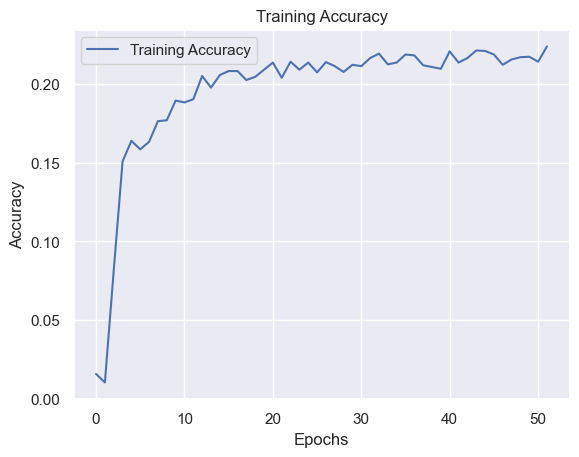

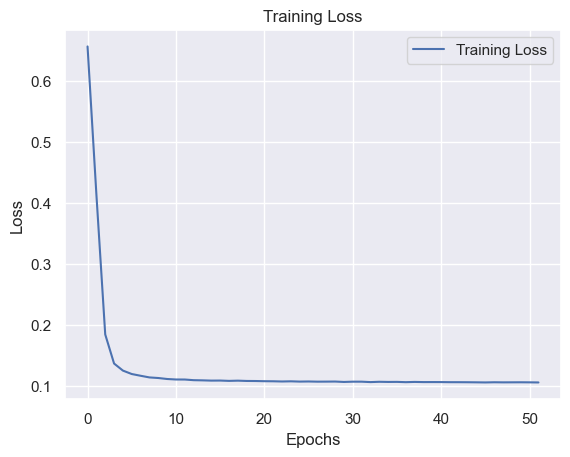

In [501]:


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [502]:
test_loss, test_accuracy = model.evaluate(X_val.toarray(), y_val.values)
print(f'Test Accuracy= {round(test_accuracy,2)*100}%\nTest Loss= {round(test_loss,2)}')

8/8 [==============================] - 0s 7ms/step - loss: 0.0959 - accuracy: 0.2198
Test Accuracy= 22.0%
Test Loss= 0.1


In [503]:


df_test.drop(columns=['index', 'Unnamed: 0', 'assessment', 'tags'], axis=1, inplace=True)
df_test.head()



,text
0,"Последнее время думаю плохо, сроки доставки давно не [NUM] мин, а цена услуг при этом выше аналогов"
1,Цены намного выше магазинных но радуют акции
2,"Доставка за [NUM] минут, заказ даже не начали собирать спустя [NUM] минут"
3,Ужасно долгая доставка
4,Добрый вечер! Вы большие молодцы. Меня всё устраивает. За исключением некоторых ребят на доставке.


In [504]:
df_test = df_test.fillna('')
df_test = df_test.replace('', 'хорошо')
df_test.isnull().sum()

text    0
dtype: int64

In [505]:
predict = preprocess_text(df_test)
predict.shape

(9015, 3)

In [506]:
pred=model.predict(predict.toarray())
print(pred)

282/282 [==============================] - 1s 2ms/step
[[0.13654654 0.0861817  0.4038602  ... 0.00769813 0.00630458 0.00333928]
 [0.1193154  0.03647617 0.02319145 ... 0.00606062 0.00589399 0.00158736]
 [0.238668   0.15933244 0.5292711  ... 0.00531393 0.00457009 0.00179547]
 ...
 [0.08341172 0.02929778 0.0660466  ... 0.00961412 0.01127207 0.00628973]
 [0.11931542 0.03647617 0.02319145 ... 0.00606062 0.00589399 0.00158736]
 [0.14844891 0.10305871 0.45272544 ... 0.00623308 0.0049584  0.00228098]]


In [558]:



predictions = model.predict(predict.toarray())


predicted_labels = (predictions >= 0.15).astype(int)
class_mapping={}
for i in range(50):
    class_mapping[i]=f'{i}'


results = df_test.copy()


def get_predicted_classes(label_vector):
    return ', '.join([class_mapping[i] for i, val in enumerate(label_vector) if val == 1])

results['t'] = [get_predicted_classes(label) for label in predicted_labels]

pd.set_option('display.max_colwidth', None)

multi_label_rows = results[results['t'].str.contains(',')]
multi_label_rows.head(5)




282/282 [==============================] - 1s 2ms/step


,text,t
2,"Доставка за [NUM] минут, заказ даже не начали собирать спустя [NUM] минут","0, 1, 2"
3,Ужасно долгая доставка,"0, 1"
5,Хотелось бы быструю доставку. Заказ доставляют от [NUM] минут до [NUM] часа. Часто привозят гнилые овощи фрукты,"0, 2"
9,"Все хорошо, если бы еще доставка была быстрее, цены бы не было!","0, 2"
10,"Удобно, но дорого, доставка из магазина гораздо дольше, чем [NUM],[NUM]","0, 1, 2"


In [559]:
results['index']=df_test_copy['index']
results.head()

,text,t,index
0,"Последнее время думаю плохо, сроки доставки давно не [NUM] мин, а цена услуг при этом выше аналогов",2,3135
1,Цены намного выше магазинных но радуют акции,,4655
2,"Доставка за [NUM] минут, заказ даже не начали собирать спустя [NUM] минут","0, 1, 2",22118
3,Ужасно долгая доставка,"0, 1",23511
4,Добрый вечер! Вы большие молодцы. Меня всё устраивает. За исключением некоторых ребят на доставке.,,45


In [560]:
f=open('submission.csv', 'w')
f.write("index,target")
f.write("\n")
for i in range(len(results)):
    
    f.write(str(results['index'][i]))
    f.write(',')
    a=results['t'][i].replace(',', '')
    f.write(a)
    
    f.write("\n")

f.close()